In [1]:
# Load necessary modules and dataset 
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyber-gpu/lib/python3.10/site-packages")

import matplotlib.pyplot as plt
from functions import *
from utils import *

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # add this
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

jax.config.update("jax_enable_x64", True)

KeyboardInterrupt: 

In [2]:
# Load the data from the dataset 
dataset_dir = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/dataset_100_10_20_10_1000_40.0_10000.pkl'

dataset_list, param_dict = load_dataset(dataset_dir)

In [28]:
template_list = dataset_list[0]['template_chain_list']
X = dataset_list[0]['observation_list']
label_list = dataset_list[0]['labels']

observations_flatten = [squareform(pdist(x)).flatten() for x in X]

# generate weight of each label from label_list
true_weights = np.array([np.sum(label_list == i) for i in np.unique(label_list)]) / len(label_list)
templates_flatten = [squareform(pdist(x)).flatten() for x in template_list]

# Generate random walk for guessing structures
num_monomers = param_dict['num_monomers']
mean_bond_length = param_dict['mean_bond_length']
std_bond_length = param_dict['std_bond_length'] 
num_templates = param_dict['num_templates']
measurement_error = param_dict['noise_std']
num_observations = param_dict['num_observations']
num_probes = num_monomers
num_candidates = num_templates

In [4]:
# Visualize the image of flatten distance map
observations_flatten = np.array(observations_flatten)
observations_flatten.shape 

(10003, 10000)

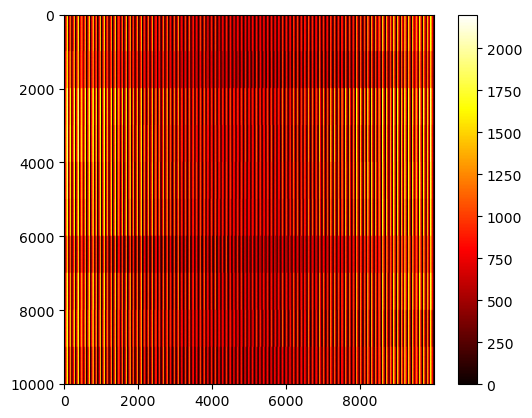

In [5]:
plt.imshow(observations_flatten, cmap='hot')
plt.colorbar()

In [5]:
# Get shuffle indices for shuffling dataset 
shuffle_indices = np.arange(num_observations)
np.random.shuffle(shuffle_indices)

In [6]:
shuffled_observations_flatten = observations_flatten[shuffle_indices, :]


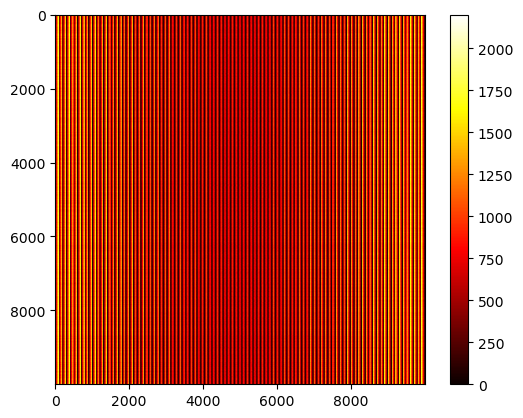

In [7]:
plt.imshow(shuffled_observations_flatten, cmap='hot')
plt.colorbar()

In [48]:
# Introducing missing data to the dataset at specific barcodes with some probabiliity between [0, 1]
missing_data_prob = np.random.normal(0.01, 0.05, num_monomers)
missing_data_prob[missing_data_prob < 0] = 0
missing_data_prob[missing_data_prob > 1] = 1


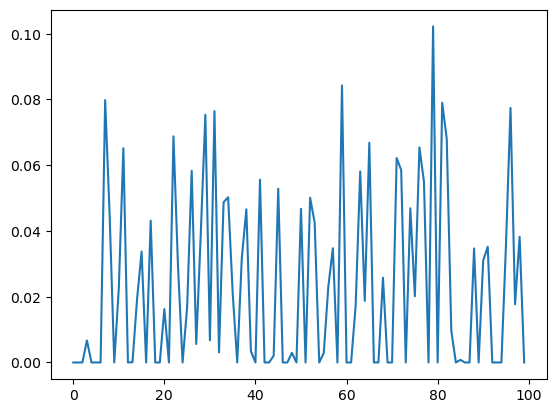

In [49]:
plt.plot(missing_data_prob)

In [50]:
observations_with_nan = np.array([squareform(pdist(x)) for x in X])
# Randomly add nan to the dataset based on the missing_data_prob
for i in range(num_observations):
    missing_indices = np.random.uniform(size=num_monomers) < missing_data_prob
    observations_with_nan[i, missing_indices, :] = np.nan
    observations_with_nan[i, :, missing_indices] = np.nan

In [51]:
observations_flatten_with_nan = np.array([x.flatten() for x in observations_with_nan])

In [43]:
import matplotlib.colors as mcolors

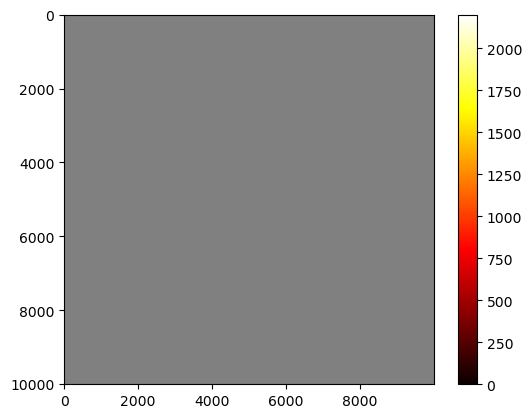

In [53]:
# Create a colormap
cmap = plt.cm.hot  # or any other colormap you prefer

# Copy the colormap to set a specific color for NaN values
cmap = cmap.copy()
cmap.set_bad(color='gray')  # Set the color for NaNs

# Create a norm that handles NaN values
norm = mcolors.Normalize(vmin=np.nanmin(observations_flatten_with_nan), vmax=np.nanmax(observations_flatten_with_nan))


plt.imshow(observations_flatten_with_nan, cmap=cmap, norm=norm)
plt.colorbar()

In [54]:
np.isnan(observations_flatten_with_nan).sum()/observations_flatten_with_nan.size

0.04645059482155353

In [8]:
# Use Low Rank completion from pylop and pyproximal 
import pylops
import pyproximal 

In [14]:
shuffled_observations_flatten = shuffled_observations_flatten[:100]

In [15]:
# Define Restriction operator
sub = 0.4
ny, nx = shuffled_observations_flatten.shape
nsub = int(ny * nx * sub)
iava = np.random.permutation(np.arange(ny, nx))[:nsub]

Rop = pylops.Restriction(ny*nx, iava)

In [21]:
shuffled_observations_flatten.shape

(100, 10000)

In [17]:
# Data 
y = Rop * shuffled_observations_flatten.ravel()

# Masked data 
Y = (Rop.H * Rop * shuffled_observations_flatten.ravel()).reshape(ny, nx)

In [18]:
X = shuffled_observations_flatten

In [19]:
# SVD of true and masked data
Ux, Sx, Vhx = np.linalg.svd(X, full_matrices=False)
Uy, Sy, Vhy = np.linalg.svd(Y, full_matrices=False)

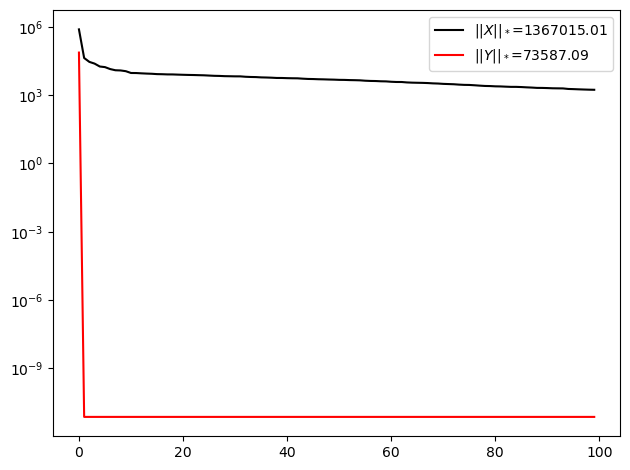

In [20]:
plt.figure()
plt.semilogy(Sx, 'k', label=r'$||X||_*$=%.2f' % np.sum(Sx))
plt.semilogy(Sy, 'r', label=r'$||Y||_*$=%.2f' % np.sum(Sy))
plt.legend()
plt.tight_layout()

In [22]:
mu = .8
f = pyproximal.L2(Rop, y)
g = pyproximal.Nuclear((ny, nx), mu)

Xpg = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                      tau=1., niter=100, show=True)
Xpg = Xpg.reshape(ny, nx)

# Recompute SVD and see how the singular values look like
Upg, Spg, Vhpg = np.linalg.svd(Xpg, full_matrices=False)

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.Nuclear'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 100
niterback = 100	acceleration = vandenberghe

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   0.00000e+00   3.200e-01   5.887e+04   5.887e+04   1.000e+00
     2   0.00000e+00   3.200e-01   5.887e+04   5.887e+04   1.000e+00
     3   0.00000e+00   3.200e-01   5.887e+04   5.887e+04   1.000e+00
     4   0.00000e+00   3.200e-01   5.887e+04   5.887e+04   1.000e+00


KeyboardInterrupt: 

In [37]:
# We should only extract the upper triangular part of the distance matrix
observations_flatten_upper = np.array([np.triu(squareform(pdist(x))).flatten() for x in X])
observations_flatten_upper_shuffled = observations_flatten_upper[shuffle_indices, :]

In [38]:
observations_flatten_upper_shuffled.shape

(10000, 10000)

In [51]:
# Define Restriction operator
sub = 0.4
ny, nx = observations_flatten_upper_shuffled.shape
nsub = int(ny * nx * sub)
iava = np.random.permutation(np.arange(ny*nx))[:nsub]

Rop = pylops.Restriction(ny*nx, iava)

In [52]:
iava

array([81671308,  6094709, 24760898, ..., 95921146, 75237582, 86079877])

In [53]:
# Data 
y = Rop * observations_flatten_upper_shuffled.ravel()

# Masked data 
Y = (Rop.H * Rop * observations_flatten_upper_shuffled.ravel()).reshape(ny, nx)

In [54]:
X_ = observations_flatten_upper_shuffled

In [55]:
# SVD of true and masked data
Ux, Sx, Vhx = jnp.linalg.svd(X_, full_matrices=False)
Uy, Sy, Vhy = jnp.linalg.svd(Y, full_matrices=False)

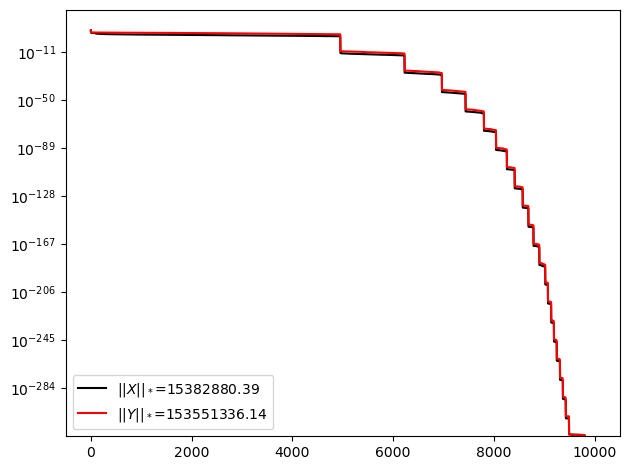

In [56]:
plt.figure()
plt.semilogy(Sx, 'k', label=r'$||X||_*$=%.2f' % np.sum(Sx))
plt.semilogy(Sy, 'r', label=r'$||Y||_*$=%.2f' % np.sum(Sy))
plt.legend()
plt.tight_layout()

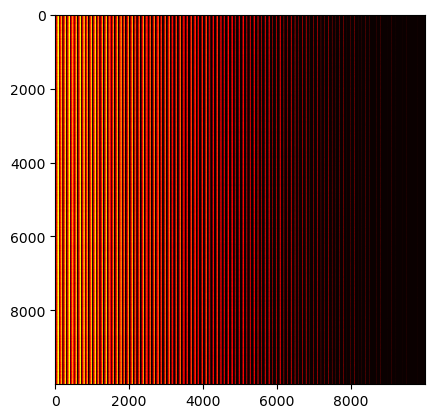

In [44]:
plt.imshow(X_, cmap='hot')

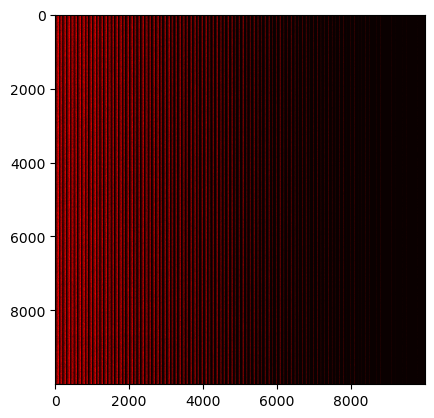

In [57]:
plt.imshow(Y, cmap='hot')

In [59]:
mu = .8
f = pyproximal.L2(Rop, y)
g = pyproximal.Nuclear((ny, nx), mu)

Xpg = pyproximal.optimization.primal.ProximalGradient(f, g, np.zeros(ny*nx), acceleration='vandenberghe',
                                                      tau=1., niter=100, show=True)
Xpg = Xpg.reshape(ny, nx)

# Recompute SVD and see how the singular values look like
Upg, Spg, Vhpg = np.linalg.svd(Xpg, full_matrices=False)

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Nuclear.Nuclear'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 100
niterback = 100	acceleration = vandenberghe

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   8.06963e-11   9.437e+02   1.228e+08   1.228e+08   1.000e+00
     2   9.48800e-11   9.438e+02   1.228e+08   1.228e+08   1.000e+00


KeyboardInterrupt: 

In [11]:
import jax
import jax.numpy as jnp
from jaxopt import ProximalGradient
from jaxopt import objective

ny, nx = shuffled_observations_flatten.shape
nsub = int(ny * nx * sub)

# Generate random permutation for indices
key = jax.random.PRNGKey(0)
iava = jax.random.permutation(key, jnp.arange(ny * nx))[:nsub]

# Observed data
y = jnp.dot(Rop, shuffled_observations_flatten.ravel())

# Masked data
Y = jnp.dot(Rop.T, y).reshape(ny, nx)

# Define the objective function f (L2 norm)
def f(X):
    return 0.5 * jnp.sum((jnp.dot(Rop, X) - y) ** 2)

# Define the proximal operator for the nuclear norm g
def prox_nuclear(X, t):
    U, S, Vh = jnp.linalg.svd(X, full_matrices=False)
    S_thresholded = jax.nn.relu(S - mu * t)
    return jnp.dot(U, jnp.dot(jnp.diag(S_thresholded), Vh))

# Define the prox-g function (wrapper for jaxopt)
def g_prox(X, t):
    return prox_nuclear(X.reshape((ny, nx)), t).reshape(-1)

# Initialize X
X_init = jnp.zeros(ny * nx)

# Define the optimization problem
solver = ProximalGradient(fun=f, prox_g=g_prox, maxiter=100, acceleration=True, tol=1e-5)

# Run the solver
solution = solver.run(init_params=X_init)

# Reshape the result
Xpg = solution.params.reshape(ny, nx)

# Compute SVD
Upg, Spg, Vhpg = jnp.linalg.svd(Xpg, full_matrices=False)

# Show the singular values
print(Spg)

2024-07-19 17:09:58.383308: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2410] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to allocate request for 28.42PiB (32000000000000000B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         8B
              constant allocation:         0B
        maybe_live_out allocation:   28.42PiB
     preallocated temp allocation:         0B
                 total allocation:   28.42PiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 28.42PiB
		Operator: op_name="jit(broadcast_in_dim)/jit(main)/broadcast_in_dim[shape=(40000000, 100000000) broadcast_dimensions=()]" source_file="/tmp/ipykernel_1024211/4136127126.py" source_line=14
		XLA Label: broadcast
		Shape: f64[40000000,100000000]

	Buffer 2:
		Size: 8B
		Entry Parameter Subshape: f64[]




XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to allocate request for 28.42PiB (32000000000000000B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         8B
              constant allocation:         0B
        maybe_live_out allocation:   28.42PiB
     preallocated temp allocation:         0B
                 total allocation:   28.42PiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 28.42PiB
		Operator: op_name="jit(broadcast_in_dim)/jit(main)/broadcast_in_dim[shape=(40000000, 100000000) broadcast_dimensions=()]" source_file="/tmp/ipykernel_1024211/4136127126.py" source_line=14
		XLA Label: broadcast
		Shape: f64[40000000,100000000]
		==========================

	Buffer 2:
		Size: 8B
		Entry Parameter Subshape: f64[]
		==========================



In [13]:
Rop.shape

(0, 100000000)